# Approximate nearest neighbor indexing

We have used the [Annoy](https://github.com/spotify/annoy) (Approximate Nearest Neighbors Oh Yeah) library for ANN indexing. Annoy constructs an ensemble of random projection index trees by recursively splitting the data space into subspaces using random split hyperplanes.

We will illustrate in a two-dimensional space how the ANN index is constructed and how it can be used for speeding up nearest neighbor queries below.

This code is based on [erikbern/ann-presentation](https://github.com/erikbern/ann-presentation).

In [1]:
%matplotlib inline
import descartes
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import nxpd
import seaborn as sns
import shapely.geometry as sg
import shapely.ops as so
import sklearn.datasets

In [2]:
sns.set_style('white')

MAX_LEAF_SIZE = 25

In [3]:
class TreeNode:
    
    def __init__(self, points, parent=None, surface=None, level=None):
        self.parent = parent
        self.left = None
        self.right = None
        self.level = parent.level + 1 if parent is not None else 0
        
        self.points = points
        self.surface = (
            surface if surface is not None else
            sg.Polygon([(20, 20), (20, -20), (-20, -20), (-20, 20)])
        )
        
        # split the internal node
        if len(points) > MAX_LEAF_SIZE and level != 0:
            # compute a split hyperplane between two random points
            p1, p2 = points[np.random.choice(points.shape[0], 2, False), :]
            v = p2 - p1
            m = np.mean([p1, p2], axis=0)
            a = np.dot(v, m)
            v_perp = np.asarray([v[1], -v[0]])
    
            # assign the points to child nodes
            idx_left = np.where(np.dot(points, v) - a >= 0)[0]
            idx_right = np.setdiff1d(np.arange(len(points)), idx_left, True)
            
            surface_left = sg.Polygon(
                    np.array([m + v_perp * 1e6, m + v * 1e6, m - v_perp * 1e6])
            ).intersection(self.surface)
            surface_right = sg.Polygon(
                    np.array([m + v_perp * 1e6, m - v * 1e6, m - v_perp * 1e6])
            ).intersection(self.surface)

            # recursively split into child nodes
            child_level = level - 1 if level is not None else None
            self.left = TreeNode(points[idx_left], self,
                                 surface_left, child_level)
            self.right = TreeNode(points[idx_right], self,
                                  surface_right, child_level)

In [4]:
def dfs_tree(root):
    stack = [root]
    while stack:
        node = stack.pop()
        yield node
        if node.right is not None:
            stack.append(node.right)
        if node.left is not None:
            stack.append(node.left)

In [5]:
def plot_subspaces(node, query=None, colormap='gist_rainbow',
                   level=None, filename=None):
    fig, ax = plt.subplots(figsize=(7, 7))
    
    # plot the points
    ax.scatter(node.points[:, 0], node.points[:, 1],
               c='black', marker='.', zorder=5)
    
    # plot the query point
    if query is not None:
        ax.scatter(query[0], query[1], s=300, c='red', marker='X',
                   edgecolor='black', linewidth='3', zorder=10)
        query_point = sg.Point(*query)
    else:
        query_point = None
    
    # plot the subspaces
    max_depth = max([n.level for n in dfs_tree(node)]) + 1
    max_nodes = sum([2 ** i for i in range(max_depth)])
    colors = sns.color_palette(colormap, max_nodes)
    
    def process_node(current_node, current_colors):
        if query_point is not None and\
                not current_node.surface.contains(query_point):
            color = 'white'
        else:
            color = current_colors[len(current_colors) // 2]
        
        if level is None or current_node.level <= level:
            ax.add_patch(descartes.PolygonPatch(
                    current_node.surface, facecolor=color,
                    edgecolor='darkgray', zorder=0))
        
        sep = len(current_colors) // 2
        if current_node.left is not None:
            process_node(current_node.left, current_colors[:sep])
        if current_node.right is not None:
            process_node(current_node.right, current_colors[sep + 1:])
    
    process_node(node, colors)
    
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.axis('off')
    
    if filename is not None:
        plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()

In [6]:
def plot_ensemble(nodes, query, filename=None):
    fig, ax = plt.subplots(figsize=(7, 7))
    
    # plot the points
    ax.scatter(nodes[0].points[:, 0], nodes[0].points[:, 1],
               c='black', marker='.', zorder=5)
    
    # plot the query point
    ax.scatter(query[0], query[1], s=300, c='red', marker='X',
               edgecolor='black', linewidth='3', zorder=10)
    query_point = sg.Point(*query)
    
    # get the query's subspace from all trees
    subspaces = []
    for node in nodes:
        for current_node in dfs_tree(node):
            is_leaf = current_node.left is None and current_node.right is None
            if is_leaf and current_node.surface.contains(query_point):
                subspaces.append(current_node.surface)
    
    ax.add_patch(descartes.PolygonPatch(
            so.cascaded_union(subspaces), facecolor='none', edgecolor='black',
            hatch='x', linewidth=2.0, zorder=0))
    
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.axis('off')
    
    if filename is not None:
        plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()

In [7]:
def plot_tree(node, query=None, colormap='gist_rainbow',
              level=None, filename=None):
    tree = nx.DiGraph()
    
    query_point = sg.Point(*query) if query is not None else None
    
    max_depth = max([n.level for n in dfs_tree(node)]) + 1
    max_nodes = sum([2 ** i for i in range(max_depth)])
    colors = sns.color_palette(colormap, max_nodes)
    
    def process_node(current_node, current_colors):
        color = current_colors[len(current_colors) // 2]
        if level is None or current_node.level <= level:
            is_leaf = ((current_node.left is None and
                        current_node.right is None) or
                       current_node.level == level)
            attrs = {'style': 'filled', 'fontsize': 24, 'fontname': 'bold',
                     'label': current_node.points.shape[0] if is_leaf else '""',
                     'shape': 'circle' if is_leaf else 'square'}
            if query_point is not None:
                if not current_node.surface.contains(query_point):
                    attrs['fillcolor'] = '#ffffff'  # white
                else:
                    attrs['fillcolor'] = mcolors.rgb2hex(color)
                    attrs['penwidth'] = 10
            else:
                attrs['fillcolor'] = mcolors.rgb2hex(color)

            tree.add_node(current_node, **attrs)
            if current_node.parent is not None:
                tree.add_edge(current_node.parent, current_node)
        
        sep = len(current_colors) // 2
        if current_node.left is not None:
            process_node(current_node.left, current_colors[:sep])
        if current_node.right is not None:
            process_node(current_node.right, current_colors[sep + 1:])
            
    process_node(node, colors)
    
    if filename is not None:
        nxpd.draw(tree, filename=filename, show=False,
                  args=['-Gsize=10,10!', '-Gratio=fill', '-Gdpi=100'])
    return tree

In [8]:
def get_points():
    X, y = sklearn.datasets.make_blobs(500, 2, centers=10, center_box=(-10, 10))
    return X

In [9]:
np.random.seed(1)
points = get_points()
query = (-7, -2.8)

The data space is partitioned into two subspaces using a random split hyperplane.

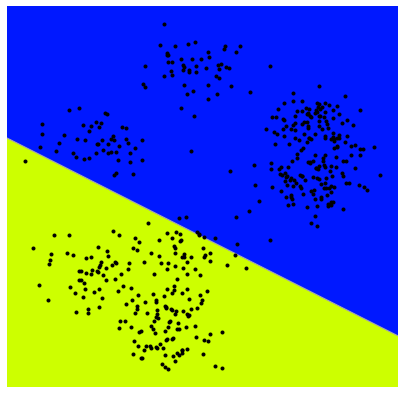

In [10]:
np.random.seed(1)
root = TreeNode(points)
plot_subspaces(root, level=1, filename='index-subspaces_level1.pdf')

Each subspace can recursively be partitioned further.

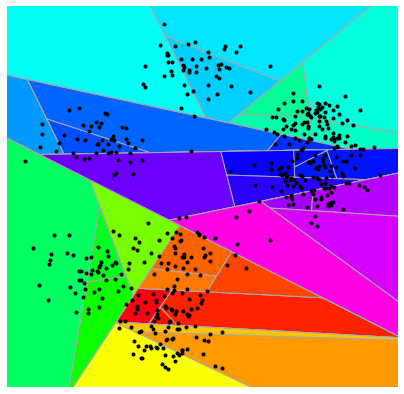

In [11]:
plot_subspaces(root, filename='index-subspaces.pdf')

This can be represented as a binary index tree.

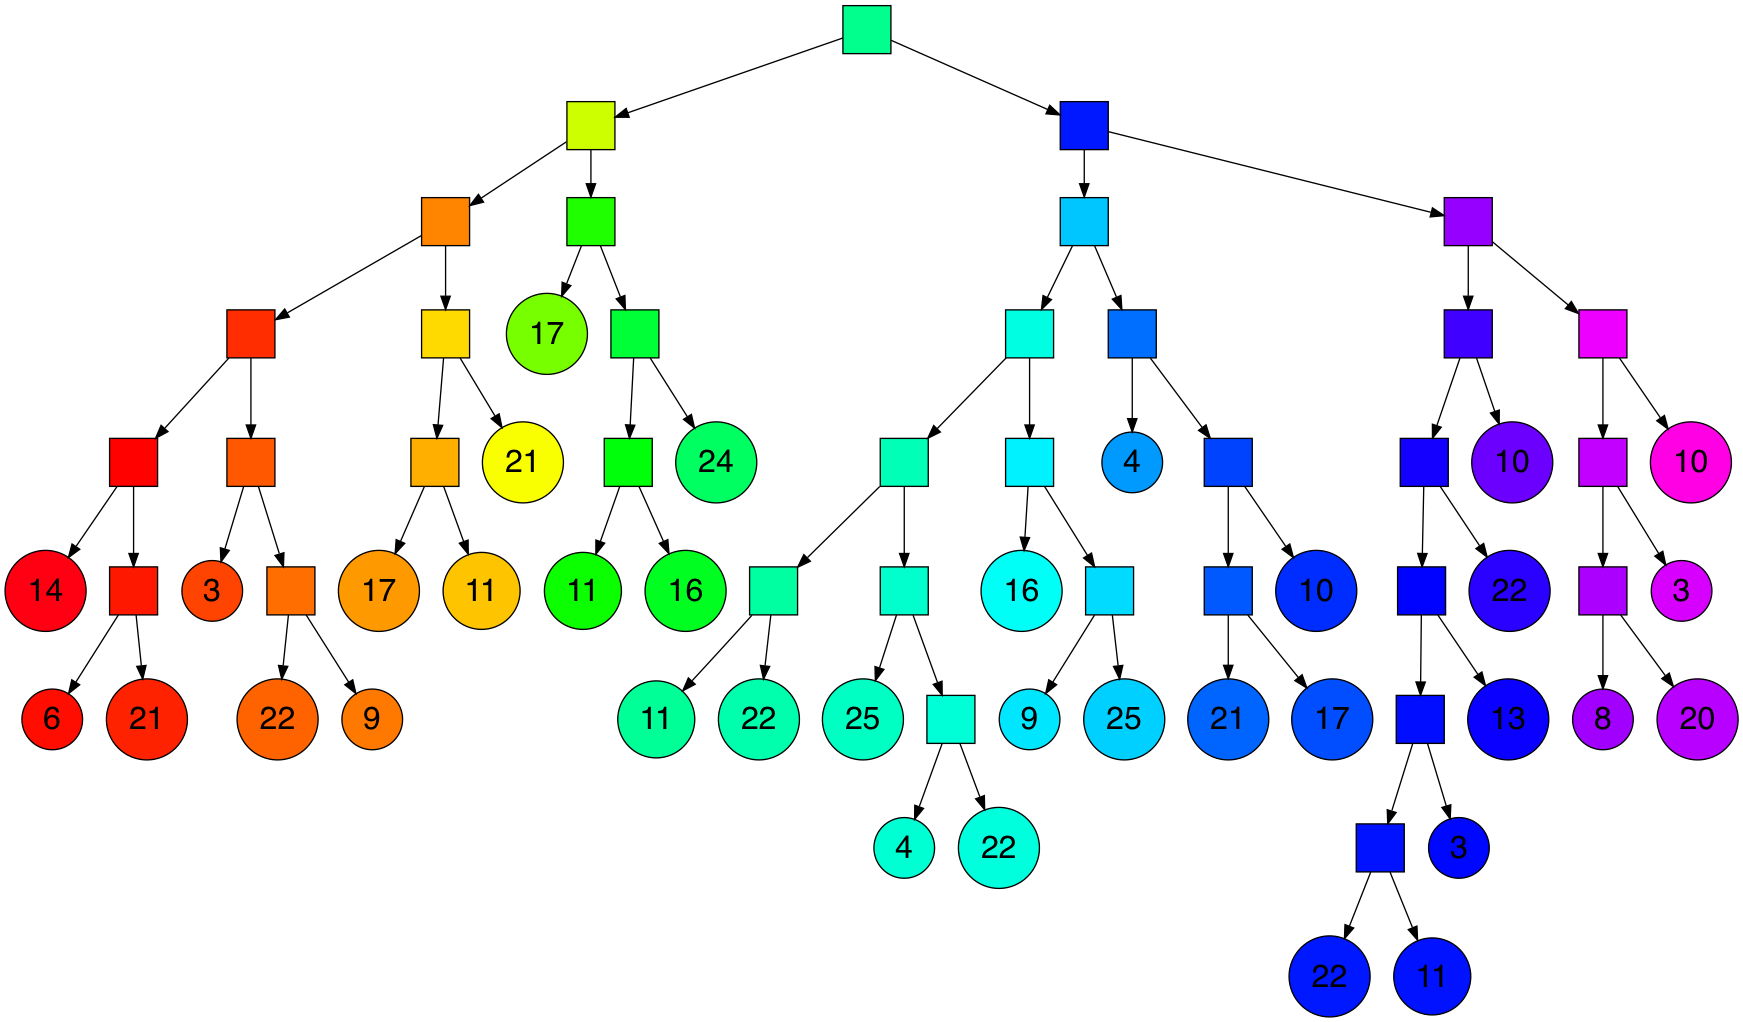

In [12]:
tree = plot_tree(root, filename='index-tree.pdf')
nxpd.draw(tree, show='ipynb')

The data subspace to which a query item belongs is retrieved to find its nearest neighbors.

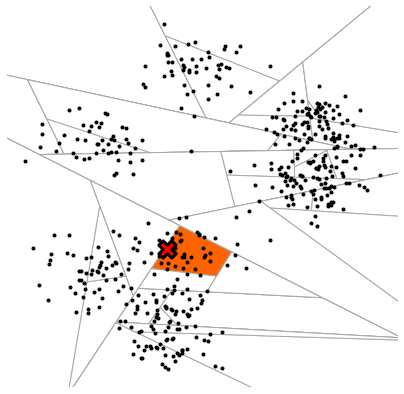

In [13]:
plot_subspaces(root, query, filename='index-subspaces_query.pdf')

This subspace can be found efficiently using the binary index tree.

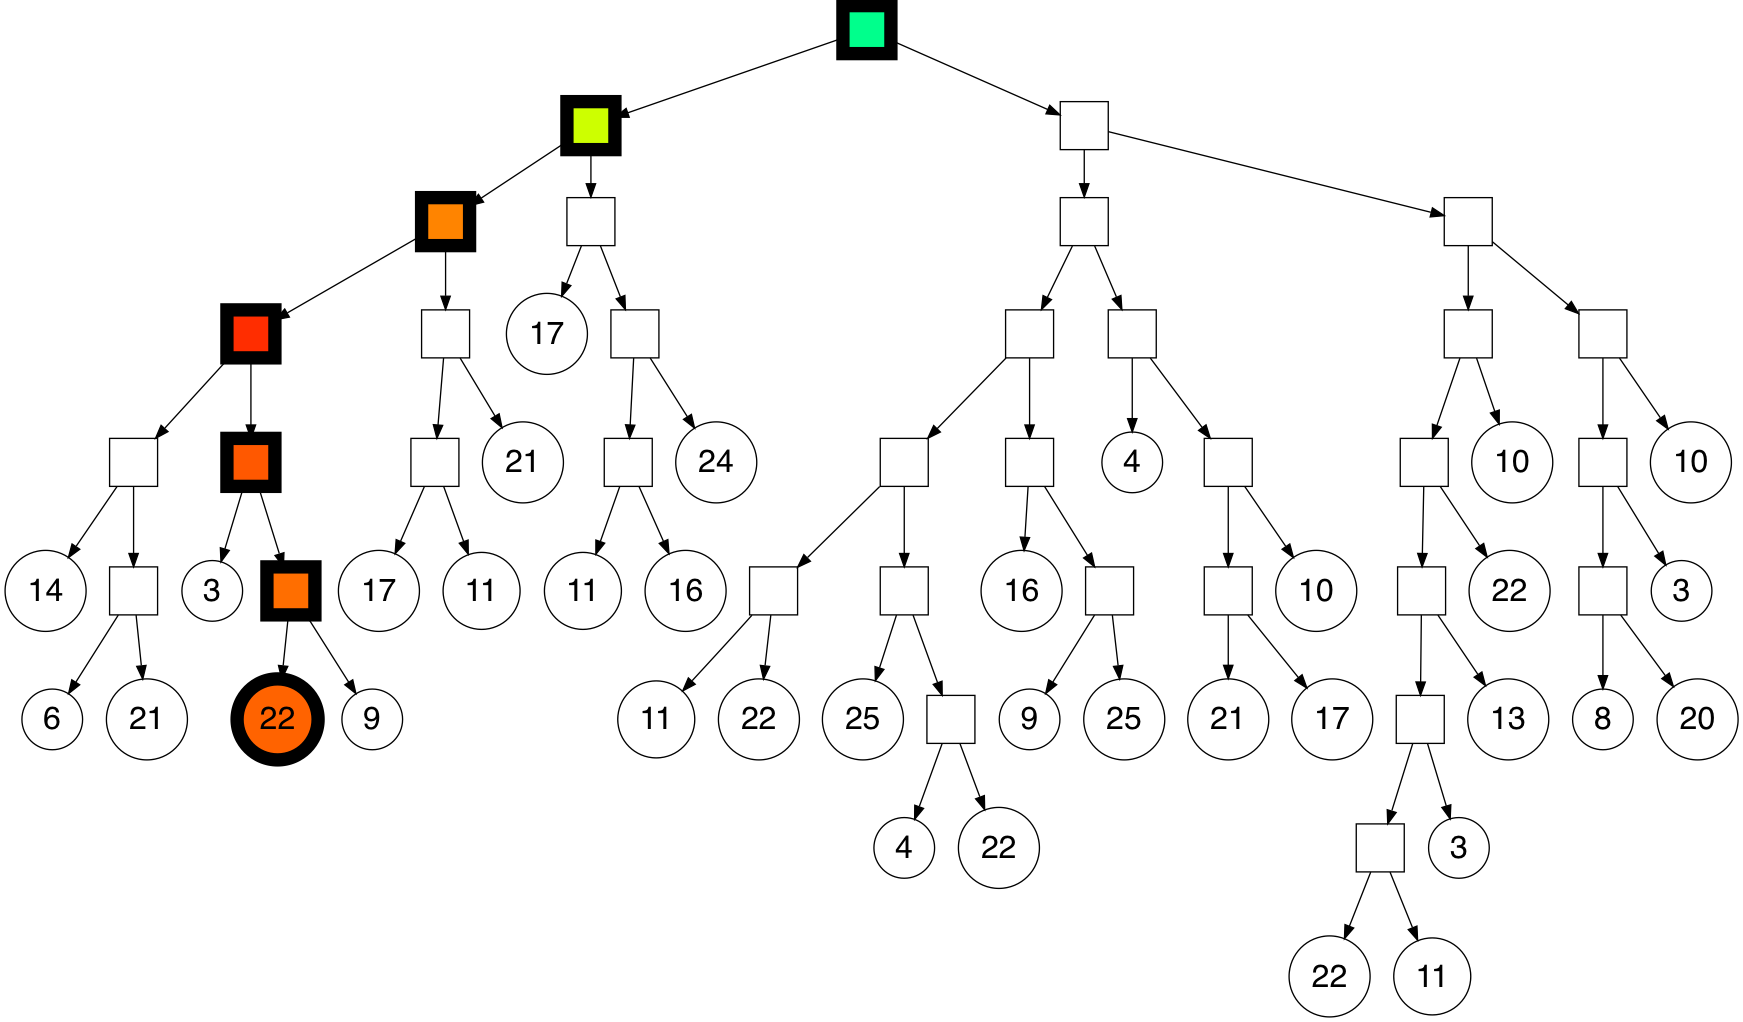

In [14]:
tree = plot_tree(root, query, filename='index-tree_query.pdf')
nxpd.draw(tree, show='ipynb')

A composite data subspace can be compiled from multiple index trees to obtain a better approximation.

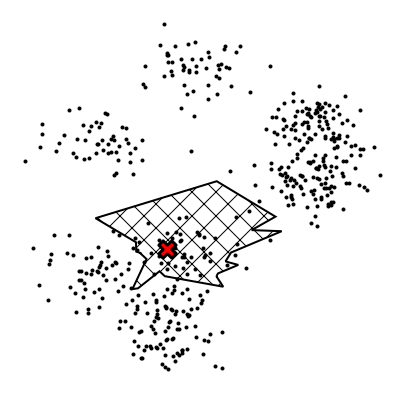

In [15]:
trees = [root]
for _ in range(5):
    trees.append(TreeNode(points))
plot_ensemble(trees, query, 'index-ensemble.pdf')